<a href="https://colab.research.google.com/github/jqhoogland/implicit-self-regularization/blob/master/rmt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install torch transformers ipywidgets powerlaw


You should consider upgrading via the 'C:\Users\rauno\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [19]:
# from typing import Literal

import numpy as np
import torch as t
from torch import nn
import ipywidgets as widgets
from matplotlib import pyplot as plt
import powerlaw

In [20]:
def marchenko_pastur_pdf(x_min: float, x_max: float, Q: float, sigma=1):
    y = 1 / Q
    x = np.arange(x_min, x_max, 0.001)

    b = np.power(sigma * (1 + np.sqrt(1 / Q)), 2) # Largest eigenvalue
    a = np.power(sigma * (1 - np.sqrt(1 / Q)), 2) # Smallest eigenvalue
    return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))

# @widgets.interact(x_min=0., x_max=4., Q=(0.5, 20.))
def plot_marchenko_pastur_pdf(x_min: float, x_max: float, Q: float, sigma=1):
    x, y = marchenko_pastur_pdf(x_min, x_max, Q, sigma)
    plt.plot(x, y)

In [21]:
def calc_sigma(Q, evs):
    lmax = np.max(evs)
    inv_sqQ = 1.0/np.sqrt(Q)
    sigma_2 = lmax/np.square(1+inv_sqQ)
    sigma = np.sqrt(sigma_2)
    return sigma

$$\sigma^{2}=\lambda_{max}\left(1+\dfrac{1}{\sqrt{Q}}\right)^{-2}$$

In [22]:
def calc_lambda_plus(Q: float, sigma: float):
    return np.power(sigma*(1 + np.sqrt(1/Q)),2)

def calc_lambda_minus(Q: float, sigma: float):
    return np.power(sigma*(1 - np.sqrt(1/Q)),2)

def calc_sigma(Q: float, evs: np.ndarray):
    lmax = np.max(evs)
    inv_sqQ = 1.0 / np.sqrt(Q)
    sigma_2 = lmax / np.square(1 + inv_sqQ)
    sigma = np.sqrt(sigma_2)

    return sigma

def get_Q(W: np.ndarray):
    M, N = W.shape

    if M > N:
        M, N = N, M

    return N / M

def get_svs_squared(W: np.ndarray, norm=False):
    N, M = W.shape
    if N < M:
        X = np.dot(W,W.transpose())
        
    else:
        X = np.dot(W.transpose(),W)
       
    # assumes matrix is full rank
    if norm:
        X = X/np.trace(X)
        
    return np.linalg.eig(X)[0]


In [23]:
def plot_ESD_and_fit(rect_matrix: np.ndarray, num_spikes=0, Q=None, sigma=None,
                     alpha=0.25, color='blue', skip=False, verbose=True):
    """Plot histogram of eigenvalues, for Q, and fit Marchenk Pastur.  
    If no sigma, calculates from maximum eigenvalue (minus spikes)
    Can read keras weights from model if specified.  Does not read PyTorch"""
    eigenvalues = get_svs_squared(rect_matrix)
   
    if skip:
        plt.hist(eigenvalues, bins=100, alpha=alpha, color=color, density=True, label=r'$\rho_{emp}(\lambda)$')
        return
        
    # sort, descending order, minus a few max eigenvalues (the spikes)
    evals = np.sort(eigenvalues)[::-1][num_spikes:]

    if Q is None:
        Q = get_Q(rect_matrix)

    if sigma is None:
        sigma = calc_sigma(Q, evals)
        
    percent_mass = 100.0 * num_spikes / len(evals)

    x_min, x_max =  0, np.max(evals)

    xs, ys = marchenko_pastur_pdf(x_min, x_max, Q, sigma)
    print(x_min, x_max, Q, sigma, xs)

    if verbose:
        print("% spikes outside bulk {0:.2f}".format(percent_mass))
        print("% sigma {0:.4f}".format(sigma))

    fig,ax = plt.subplots()
    ax.plot(xs, ys, linewidth=1, color = 'r', label="MP fit")
    ax2 = ax.twinx()
    ax2.hist(eigenvalues, bins=100, alpha=alpha, color=color, density=True, label=r'$\rho_{emp}(\lambda)$')
    plt.title(" ESD, MP Sigma={}".format( sigma))
    return sigma

In [24]:
def gen_matrix(N: int, M: int, sigma=1.):
    return np.random.normal(size=(N, M), loc=0., scale=sigma**2)

C:\Users\rauno\AppData\Local\Temp\ipykernel_30648\3277450928.py:7: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
C:\Users\rauno\AppData\Local\Temp\ipykernel_30648\3277450928.py:7: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


0 4441.063981319574 4.0 44.427538913604145 [0.000000e+00 1.000000e-03 2.000000e-03 ... 4.441061e+03 4.441062e+03
 4.441063e+03]
% spikes outside bulk 0.00
% sigma 44.4275


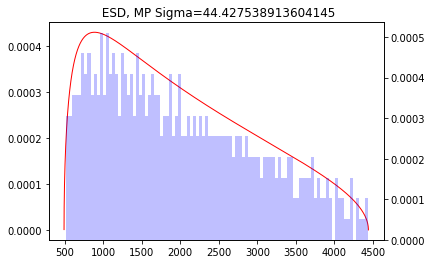

In [25]:
test_matrix_1 = gen_matrix(500, 2000)
plot_ESD_and_fit(test_matrix_1)
plt.show()

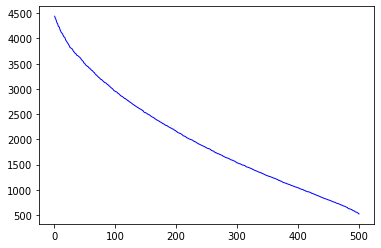

In [26]:
def scree_plot(matrix: np.ndarray, color='blue',label=''):    
    evs = get_svs_squared(matrix)
    eigvals = np.flip(np.sort(evs), axis=0)
    sing_vals = np.arange(len(eigvals)) + 1
    plt.plot(sing_vals, eigvals, color, linewidth=1,label=label)

scree_plot(test_matrix_1)

In [27]:
def get_mu(alpha):
    if (alpha >= 2.0 and alpha <= 3.0):
        mu = 2.0
    elif (alpha < 2.0):
        mu = 2.0*(alpha - 1.0)
    elif (alpha > 3.0):
        mu = alpha - 1.0
    return mu

def best_dist(fit):
    distName = 'power_law'
    dist = "PL"

    R, p = fit.distribution_compare('truncated_power_law', 'power_law', normalized_ratio=True)
    if R>0 and p <= 0.05:
        distName = 'truncated_power_law'
        dist = 'TPL'
        
    R, p = fit.distribution_compare(distName, 'exponential', normalized_ratio=True)
    if R<0 and p <= 0.05:
        dist = 'EXP'
        return dist

    R, p = fit.distribution_compare(distName, 'stretched_exponential', normalized_ratio=True)
    if R<0 and p <= 0.05:
        dist = 'S_EXP'
        return dist
        
    R, p = fit.distribution_compare(distName, 'lognormal', normalized_ratio=True)
    if R<0 and p <= 0.05:
        dist = 'LOG_N'
        return dist

    return dist

def fit_powerlaw(evals, verbose=True):
    fit = powerlaw.Fit(evals, xmax=np.max(evals))
    return [fit.alpha, fit.D, best_dist(fit)]

def pareto_pdf(x_min: float, x_max: float, mu=1., scale=1.):
    scale = mu

    xs = np.arange(x_min  + 0.001, x_max, 0.001)
    ys = mu * scale**mu / xs**(mu+1)
    return xs, ys 


In [28]:
def fit_and_plot_powerlaw(matrix: np.ndarray, verbose=True):
    evals = get_svs_squared(matrix)
    fit = powerlaw.Fit(evals, xmax=np.max(evals))
    
    alpha, D, best_pl = fit.alpha, fit.D, best_dist(fit)
    
    print("alpha {:3g}, D {:3g}, best_pl  {}".format(alpha, D, best_pl))
    
    fig2 = fit.plot_pdf(color='b', linewidth=2)
    fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
    fit.plot_ccdf(color='r', linewidth=2, ax=fig2)
    fit.power_law.plot_ccdf(color='r', linestyle='--', ax=fig2)
    plt.show()           

def fit_and_plot_powerlaw_with_bulk(rect_matrix: np.ndarray, Q=None, sigma=None,
                     alpha=0.25, color='blue', skip=False, verbose=True):
    eigenvalues = get_svs_squared(rect_matrix)
    evals = np.sort(eigenvalues)[::-1]
   
    if skip:
        bins = np.logspace(np.log10(np.min(evals)), np.log10(np.max(evals)), num=100)
        plt.xscale('log')
        plt.title(r'$\rho_{emp}(\lambda)$  $\mathbf{W}(\mu=1.2)$')
        plt.xlabel("Log Log Histogram")
        plt.ylabel(r"$\rho_{emp}(x)$")
        plt.tight_layout()
        plt.hist(eigenvalues, bins=bins, log=True, alpha=alpha, color=color, density=True, label=r'$\rho_{emp}(\lambda)$')
        return
        
    # sort, descending order, minus a few max eigenvalues (the spikes)

    fit = powerlaw.Fit(evals, xmax=np.max(evals))
    alpha, D, dist = fit.alpha, fit.D, best_dist(fit)
    mu = get_mu(alpha)

    scale = 1.

    x_min, x_max = 0, np.max(evals)

    if dist == "PL":
        print(mu, scale)
        xs, ys = pareto_pdf(x_min, x_max, mu, scale)
    else:
        raise NotImplementedError("Non-PL fit not supported")

    if verbose:
        print("% mu {0:.4f} scale {0:.4f}".format(mu, scale))

    fig, ax = plt.subplots()
    ax.plot(np.log(xs), np.log(ys), linewidth=1, color = 'r', label="MP fit")
    ax.set_xscale('log')
    ax.set_title(r'$\rho_{emp}(\lambda)$  $\mathbf{W}(\mu=1.2)$')
    ax.set_xlabel("Log Log Histogram")
    ax.set_ylabel(r"$\rho_{emp}(x)$")
    ax2 = ax.twinx()
    bins = np.logspace(np.log10(np.min(evals)), np.log10(np.max(evals)), num=100)
    ax2.hist(eigenvalues, log=True, bins=bins, density=True, label=r'$\rho_{emp}(\lambda)$')
    plt.tight_layout()
    fig.show()


In [29]:
# HT_Dist = Literal["PL", "TPL", "EXP", "S_EXP", "LOG_N"]

def gen_heavy_tail_matrix(N: int, M: int, alpha=6., mu=None, scale=1., sigma=0, mean=1, dist="PL"):
    if mu is None:
        mu = get_mu(alpha)

    if dist == "PL":
        # return (np.random.pareto(mu, size=(N, M)) + 1) * scale
        return np.random.pareto(mu, size=(N, M))

    raise NotImplementedError()
  


In [30]:
@widgets.interact(N=(100, 400), Q=(1., 10), mu=(1., 10.), scale=(0.5, 10.))
def plot_ht(N=150, Q=3.,  mu=3., scale=1.):
    M = int(N * Q)
    test_ht_matrix = gen_heavy_tail_matrix(N, M, mu=mu, scale=scale)
    fit_and_plot_powerlaw_with_bulk(test_ht_matrix)

interactive(children=(IntSlider(value=150, description='N', max=400, min=100), FloatSlider(value=3.0, descript…

## Loading the pretrained model

In [58]:
from transformers import GPT2Tokenizer, GPT2Model
import numpy as np
import pickle
import torch 

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')
attention_weight_matrix = []
mlp_weight_matrix = []
for name, param in model.named_parameters():
    print(name, param.shape)

for name, param in model.named_parameters():
    print(name, param.shape)
    if name.__contains__("attn") and name.__contains__("weight") and not name.__contains__("proj"):
        attention_weight_matrix.append(param.detach().numpy())
    elif name.__contains__("mlp") and name.__contains__("weight") and not name.__contains__("proj"):
        mlp_weight_matrix.append(param.detach().numpy())

print(len(attention_weight_matrix))
print(len(mlp_weight_matrix))

with open("attention_weights", 'wb') as f:
    pickle.dump(attention_weight_matrix, f)

with open("mlp_weights", 'wb') as f:
    pickle.dump(mlp_weight_matrix, f)

#this is how you load it again
with open("attention_weights", 'rb') as f:
    attention_weight_matrix = pickle.load( f)

with open("mlp_weights", 'rb') as f:
    mlp_weight_matrix = pickle.load( f)


wte.weight torch.Size([50257, 768])
wpe.weight torch.Size([1024, 768])
h.0.ln_1.weight torch.Size([768])
h.0.ln_1.bias torch.Size([768])
h.0.attn.c_attn.weight torch.Size([768, 2304])
h.0.attn.c_attn.bias torch.Size([2304])
h.0.attn.c_proj.weight torch.Size([768, 768])
h.0.attn.c_proj.bias torch.Size([768])
h.0.ln_2.weight torch.Size([768])
h.0.ln_2.bias torch.Size([768])
h.0.mlp.c_fc.weight torch.Size([768, 3072])
h.0.mlp.c_fc.bias torch.Size([3072])
h.0.mlp.c_proj.weight torch.Size([3072, 768])
h.0.mlp.c_proj.bias torch.Size([768])
h.1.ln_1.weight torch.Size([768])
h.1.ln_1.bias torch.Size([768])
h.1.attn.c_attn.weight torch.Size([768, 2304])
h.1.attn.c_attn.bias torch.Size([2304])
h.1.attn.c_proj.weight torch.Size([768, 768])
h.1.attn.c_proj.bias torch.Size([768])
h.1.ln_2.weight torch.Size([768])
h.1.ln_2.bias torch.Size([768])
h.1.mlp.c_fc.weight torch.Size([768, 3072])
h.1.mlp.c_fc.bias torch.Size([3072])
h.1.mlp.c_proj.weight torch.Size([3072, 768])
h.1.mlp.c_proj.bias torch.Siz

## Loading the finetuned model

In [61]:
attention_weight_matrix_tuned = []
mlp_weight_matrix_tuned = []
for name, param in model.named_parameters():
    print(name, param.shape)

for name, param in model.named_parameters():
    print(name, param.shape)
    if name.__contains__("attn") and name.__contains__("weight") and not name.__contains__("proj"):
        attention_weight_matrix_tuned.append(param.detach().numpy())
    elif name.__contains__("mlp") and name.__contains__("weight") and not name.__contains__("proj"):
        mlp_weight_matrix_tuned.append(param.detach().numpy())

print(len(attention_weight_matrix_tuned))
print(len(mlp_weight_matrix_tuned))

with open("attention_weights_finetuned", 'wb') as f:
    pickle.dump(attention_weight_matrix_tuned, f)

with open("mlp_weights_finetuned", 'wb') as f:
    pickle.dump(mlp_weight_matrix_tuned, f)

#this is how you load it again
with open("attention_weights_finetuned", 'rb') as f:
    attention_weight_matrix_tuned = pickle.load( f)

with open("mlp_weights_finetuned", 'rb') as f:
    mlp_weight_matrix_tuned = pickle.load( f)

wte.weight torch.Size([50257, 768])
wpe.weight torch.Size([1024, 768])
h.0.ln_1.weight torch.Size([768])
h.0.ln_1.bias torch.Size([768])
h.0.attn.c_attn.weight torch.Size([768, 2304])
h.0.attn.c_attn.bias torch.Size([2304])
h.0.attn.c_proj.weight torch.Size([768, 768])
h.0.attn.c_proj.bias torch.Size([768])
h.0.ln_2.weight torch.Size([768])
h.0.ln_2.bias torch.Size([768])
h.0.mlp.c_fc.weight torch.Size([768, 3072])
h.0.mlp.c_fc.bias torch.Size([3072])
h.0.mlp.c_proj.weight torch.Size([3072, 768])
h.0.mlp.c_proj.bias torch.Size([768])
h.1.ln_1.weight torch.Size([768])
h.1.ln_1.bias torch.Size([768])
h.1.attn.c_attn.weight torch.Size([768, 2304])
h.1.attn.c_attn.bias torch.Size([2304])
h.1.attn.c_proj.weight torch.Size([768, 768])
h.1.attn.c_proj.bias torch.Size([768])
h.1.ln_2.weight torch.Size([768])
h.1.ln_2.bias torch.Size([768])
h.1.mlp.c_fc.weight torch.Size([768, 3072])
h.1.mlp.c_fc.bias torch.Size([3072])
h.1.mlp.c_proj.weight torch.Size([3072, 768])
h.1.mlp.c_proj.bias torch.Siz

## Comparing non-finetuned weight matrices to finetuned weight matrices

In [65]:
@widgets.interact(layer=(1, 12))
def plot(layer=1):
    plot_ESD_and_fit(attention_weight_matrix[layer-1])
    plot_ESD_and_fit(attention_weight_matrix_tuned[layer-1])

interactive(children=(IntSlider(value=1, description='layer', max=12, min=1), Output()), _dom_classes=('widget…

In [66]:
@widgets.interact(layer=(1, 12))
def plot_pl(layer=1):
    fit_and_plot_powerlaw(attention_weight_matrix[layer-1])
    fit_and_plot_powerlaw(attention_weight_matrix_tuned[layer-1])

interactive(children=(IntSlider(value=1, description='layer', max=12, min=1), Output()), _dom_classes=('widget…

In [77]:
@widgets.interact(layer=(1, 12))
def plot_pl_with_bulk(layer=1):
    fit_and_plot_powerlaw_with_bulk(attention_weight_matrix[layer-1], skip=True)
    fit_and_plot_powerlaw_with_bulk(attention_weight_matrix_tuned[layer-1], skip=True)

interactive(children=(IntSlider(value=1, description='layer', max=12, min=1), Output()), _dom_classes=('widget…

In [68]:
@widgets.interact(layer=(1, 12))
def plot_mlp(layer=1):
    plot_ESD_and_fit(mlp_weight_matrix[layer-1])
    plot_ESD_and_fit(mlp_weight_matrix_tuned[layer-1])

interactive(children=(IntSlider(value=1, description='layer', max=12, min=1), Output()), _dom_classes=('widget…

In [69]:
@widgets.interact(layer=(1, 12))
def plot_mlp_pl(layer=1):
    fit_and_plot_powerlaw(mlp_weight_matrix[layer-1])
    fit_and_plot_powerlaw(mlp_weight_matrix_tuned[layer-1])

interactive(children=(IntSlider(value=1, description='layer', max=12, min=1), Output()), _dom_classes=('widget…

In [70]:
@widgets.interact(layer=(1, 12))
def plot_mlp_pl(layer=1):
    fit_and_plot_powerlaw_with_bulk(mlp_weight_matrix[layer-1], skip=True)
    fit_and_plot_powerlaw_with_bulk(mlp_weight_matrix_tuned[layer-1], skip=True)

interactive(children=(IntSlider(value=1, description='layer', max=12, min=1), Output()), _dom_classes=('widget…

## Comparing attention weight matrices to MLP weight matrices

In [71]:
@widgets.interact(layer=(1, 12))
def plot(layer=1):
    plot_ESD_and_fit(attention_weight_matrix[layer-1])
    plot_ESD_and_fit(mlp_weight_matrix[layer-1])

interactive(children=(IntSlider(value=1, description='layer', max=12, min=1), Output()), _dom_classes=('widget…

In [72]:
@widgets.interact(layer=(1, 12))
def plot_pl_with_bulk(layer=1):
    fit_and_plot_powerlaw(attention_weight_matrix[layer-1])
    fit_and_plot_powerlaw(mlp_weight_matrix[layer-1])

interactive(children=(IntSlider(value=1, description='layer', max=12, min=1), Output()), _dom_classes=('widget…

In [78]:
@widgets.interact(layer=(1, 12))
def plot_pl(layer=1):
    fit_and_plot_powerlaw_with_bulk(attention_weight_matrix[layer-1], skip=True)
    fit_and_plot_powerlaw_with_bulk(mlp_weight_matrix[layer-1], color='red', skip=True)

interactive(children=(IntSlider(value=1, description='layer', max=12, min=1), Output()), _dom_classes=('widget…

In [80]:
@widgets.interact(layer=(1, 12))
def plot_mlp(layer=1):
    plot_ESD_and_fit(mlp_weight_matrix[layer-1])
    plot_ESD_and_fit(mlp_weight_matrix_tuned[layer-1])

interactive(children=(IntSlider(value=1, description='layer', max=12, min=1), Output()), _dom_classes=('widget…

In [81]:
@widgets.interact(layer=(1, 12))
def plot_mlp_pl(layer=1):
    fit_and_plot_powerlaw(attention_weight_matrix_tuned[layer-1])
    fit_and_plot_powerlaw(mlp_weight_matrix_tuned[layer-1])

interactive(children=(IntSlider(value=1, description='layer', max=12, min=1), Output()), _dom_classes=('widget…

In [79]:
@widgets.interact(layer=(1, 12))
def plot_mlp_pl(layer=1):
    fit_and_plot_powerlaw_with_bulk(attention_weight_matrix_tuned[layer-1], skip=True)
    fit_and_plot_powerlaw_with_bulk(mlp_weight_matrix_tuned[layer-1], skip=True, color='red')

interactive(children=(IntSlider(value=1, description='layer', max=12, min=1), Output()), _dom_classes=('widget…